<a href="https://colab.research.google.com/github/himalayahall/DATA602/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Recent advancements in NLP, most notable the NLG capabilities of Large Language Models (LLM) like ChatGPT, have taken the public imagination by storm. 

NLP (Natural Language Processing), NLU (Natural Language Understanding), and NLG (Natural Language Generation) are important subtopics of Machine 
Learning. 

>**NLP:** it involves numerous tasks that break down natural language into 
smaller elements in order to understand the relationships between those elements and how they work together. NLP focuses largely on converting text to 
structured data. It does this through the identification of named entities (a process called named entity recognition) and identification of word 
patterns, using methods like tokenization, stemming, and lemmatization, which examine the root forms of words.

>**NLU:** uses syntactic and semantic analysis of text and speech to determine the meaning of text. One of the primary goals of NLU is to teach machines how to interpret and understand language inputted by humans. It leverages algorithms to recognize attributes of language such as sentiment, semantics, context, and intent.

>**NLG:** is concerned with enabling machines to not just process and understand text but to generate text. NLG is the process of producing a human language 
text response based on some data input (prompt).


## Motivation

Natural Lanaguage Generation has made major breakthroughs and caught the public imagination. It is the driving motivation for this project and it's goal to use NLP techniques for text classification and text generation.

## Dataset

>Fake reviews are a major problem in e-commerce because they misinform consumers and erode confidence in the marketplace. This [fake reviews dataset](https://osf.io/3vds7) contains 20K fake reviews and 20k real product reviews. Review labeles:
- OR = Original reviews (presumably human created and authentic)
- CG = Computer-generated fake reviews.


## Project goals
>**NLP**: 
build a classification model to classify product reviews as either original (presumably human created and authentic) or fake (presumably computer generated fake reviews).

>**NLU**:
the English learned by the pretrained language model (Wikipedia) is slightly different from the English used for product reviews. So, instead of jumping directly to the classifier, fine-tune the pretrained language model to the product corpus and use the new language model as the base for our classifier. This should (if all goes as well) result in better classifier performance.

>**NLG**:
having created a language model that was fine-tuned for product reviews, use it to auto-generate reviews. This will be done by giving the model some starting text (prompt) and asking the model to generate the rest (up to a maximum number of words).

#### Tools and Frameworks

>[Fastai](https://fastai.github.io/fastbook2e/book10.html)

>`Google Collab`

>`Jupyter Notebook`



# Load data

In [1]:
import pandas as pd
import re

df = pd.read_csv('https://raw.githubusercontent.com/himalayahall/DATA602/main/fake%20reviews%20dataset.csv')

In [2]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB
None


,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


Drop *category* and *rating* columns, rename *text_* to *text*.

In [3]:
df['text'] = df['text_']
df.drop(columns=['category', 'rating', 'text_'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   40432 non-null  object
 1   text    40432 non-null  object
dtypes: object(2)
memory usage: 631.9+ KB


In [4]:
df.head()

,label,text
0,CG,"Love this! Well made, sturdy, and very comfor..."
1,CG,"love it, a great upgrade from the original. I..."
2,CG,This pillow saved my back. I love the look and...
3,CG,"Missing information on how to use it, but it i..."
4,CG,Very nice set. Good quality. We have had the s...


## Baseline (Null) model

This dataset is balanced, i.e. number of *CG* labels = number of *OR* labels.

By definition, the *Null* model always predicts the majority class. As such, it provides an obvious baseline - i.e. any model worth considering **must** have accuracy greater than the *Null* model.

## Accuracy

Accuracy is perhaps the simplest and most intuitive metric of model performance.

$Accuracy = \frac{Number\ of\ Correct\ Predictions}{Number \ of\ Observations}$ 


For a balanced dataset like ours, the *accuracy* of the *Null* model is $50\%$. Consequently, our goal shall be to create model(s) that have $Accuracy > 50\%$.

In [5]:
cat_size = df.groupby('label').size()
print(cat_size)

prop = cat_size[0] / (cat_size[0] + cat_size[1])
print('Baseline (null model) accuracy: ' , prop)

label
CG    20216
OR    20216
dtype: int64
Baseline (null model) accuracy:  0.5


## Other Important Metrics ###

Often, specially when dealing with unbalanced datasets, *accuracy* is not the best metric for evaluating model performance. 

For example, the prevalence of cancer in the general population for USA is roughly 5.5%. Accuracy of the *Null* model for such a dataset would be 94.5%. However, for such cancer datasets the *Null* model would be completely useless at detecting cancer!

Some commonly used metrics for all types of datasets:

>**Precision** ($P$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false positives ($F_p$). 

$P = \frac{T_p}{T_p+F_p}$

>**Recall** ($R$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false negatives ($F_n$).

$R = \frac{T_p}{T_p+F_n}$ 

>**F1 Measure**, is defined as the harmonic mean of precision and recall. It is a number in the range [0.0, 1.0], the closer it is to 1.0 the better the model.  

$F1 = 2 \frac{P \times R}{P+R}$

## ML Framework

We will use the [Fastai](https://fastai.github.io/fastbook2e/book10.html) framework to build a Large Language Model (LLM). 

Fastai is a great framework that enables rapid creation of predictive models without the need to write low level code in in frameworks like Tensorflow or PyTorch.

In [6]:
from fastai.data.all import *
from fastai.text.all import *

Create data loaders for classification, build **DataBlock** using **TextBlock** and **CategoryBlock**.

Set aside 20% data using **TrainTestSplitter** for model testing. Since this dataset is perfectly balanced there is no need use stratification.

In [7]:
dls_cls = DataBlock(
            blocks=(
                TextBlock.from_df(text_cols=('text'), 
                        is_lm=False),
                CategoryBlock),
            get_x=ColReader('text'), 
            get_y=ColReader('label'),
            splitter=TrainTestSplitter(test_size=0.2, 
                                       random_state=42
                                       #,stratify=df.label
                                       )
        ).dataloaders(df)

Note - DataBlock automatically re-labels the *label* column as *category*.

In [8]:
dls_cls.show_batch(max_n = 5)

,text,category
0,"xxbos i compared this rawhide to & < a data - hook=""product - link - linked "" class=""a - link - normal "" href= "" / good - buddy - usa - rawhide - braided - sticks - for - dogs-7 - to-8 - inch-2 - count - pack - of-1 / dp / xxup b005gwvwja / ref = cm_cr_arp_d_rvw_txt?ie = utf8"">good xxmaj buddy xxup usa xxmaj rawhide xxmaj braided xxmaj sticks for xxmaj dogs , 7 to 8 - inch , 2 xxmaj count ( pack of 1 ) < / a > & for my 3 year old labradoodle . \n\n xxup where xxup it xxup is xxup made : xxmaj this is made in xxup china . xxmaj the & < a data - hook=""product - link - linked "" class=""a - link - normal "" href= "" / good - buddy - usa - rawhide -",OR
1,"xxbos xxmaj first off , let me just say we spoil our dog . xxmaj i 'm sure most people do . xxmaj for our little xxmaj maltese , we 've tried a variety of dental chews . xxmaj his favorite treats are xxmaj greenies . \n\n xxmaj after one visit to the vet , we were told that xxmaj greenies are made xxunk of wheat and that could lead to problems in the later years . xxmaj we were giving him at least two a day . xxmaj she recommended giving him one maybe every other day or on special occasions . xxmaj so the hunt began … \n\n xxmaj we 've tried all kinds . xxmaj the & < a data - hook=""product - link - linked "" class=""a - link - normal "" href= "" / xxunk - s - z - ridge - mini - fresh",OR
2,"xxbos xxmaj i 'd consider myself an advanced non - professional photographer … which means i have a xxup dslr with two lenses ( a & < a data - hook=""product - link - linked "" class=""a - link - normal "" href= "" / canon - eos - rebel - t3 / dp / xxup xxunk / ref = cm_cr_arp_d_rvw_txt?ie = xxunk xxup eos xxmaj rebel xxup t3 < / a > ) , an external flash , and a random assortment of other camera items ( an old xxmaj canon point - and - shoot , a waterproof point - and - shoot , an xxup hd video camera , the assorted xxup sd cards , lens covers , etc . ) . i currently have the el cheapo xxmaj canon bag that came with my xxmaj rebel and i barely use it , so hoped that by",OR
3,"xxbos xxmaj i 've had my xxunk for just over a month now ( bought from xxmaj amazon ) and it 's really improved my photography . xxmaj others have even commented that xxmaj i 've "" shifted to a new gear "" . xxmaj features are a nice improvement from the dslr - wannabe i had before ( panasonic xxup xxunk ) but it 's the image quality that 's really the big step up . xxmaj get the best - quality lenses for this ( * not * the kit lens ) and you 'll be very happy . \n\n xxmaj pros : \n\n * xxmaj image xxmaj quality \n * xxmaj ergonomics ( most common settings are easy to change , good displays ) \n * xxmaj battery life ( 200 shots with 50 % flash and battery still said 100 % ) \n * xxmaj the",OR
4,"xxbos < div id=""video - block - xxunk "" class=""a - section a - spacing - small a - spacing - top - mini video - block "" > < / div><input type=""hidden "" name= "" "" value=""https : / / images-na.ssl-images-amazon.com / images / i / xxunk "" class=""video - url""><input type=""hidden "" name= "" "" value=""https : / / images-na.ssl-images-amazon.com / images / i / xxunk "" class=""video - slate - img - xxunk wish i had gotten this years ago ! \n\n i picked this up for my 9 year old who loves playing baseball . xxmaj is he the best player on his team ? xxmaj no . xxmaj he wants so badly to play xxunk , but is n't the best xxunk . xxmaj he was getting discouraged about always playing in the xxunk . xxmaj he has improved with team practices , but really",OR


## Text Classifier

Create classifier. Notice,  there is no need to  pre-process text data for the classifier, e.g. create word embeddings, the framework does that automatically.

Here we are using [AWD_LST]([https://arxiv.org/pdf/1708.02182.pdf]) (averaged weght-dropped long-short term memory) model architecture.

In [9]:
learner = text_classifier_learner(dls_cls, 
                                    AWD_LSTM, 
                                    drop_mult=0.5, 
                                    metrics=[accuracy, Precision(), Recall(), F1Score()])

Calculate the optimal learning rate hyper-parameter. This will greatly influence how quickly the model converges.

SuggestedLRs(valley=0.0020892962347716093)

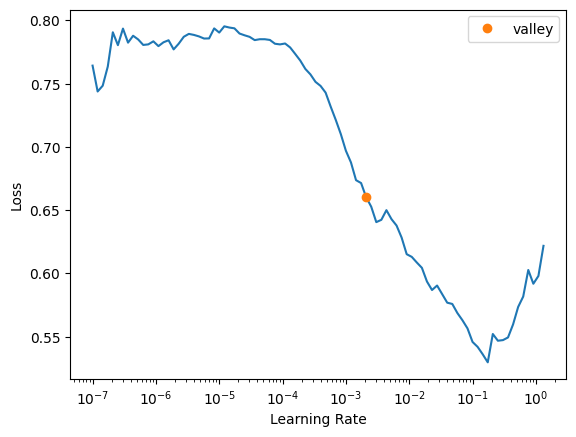

In [10]:
lr = learner.lr_find()
lr

Fine tune model for 3 epochs using the optimal learning rate.

In [11]:
learner.fine_tune(3, lr[0])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.435377,0.404571,0.828737,0.929623,0.713830,0.807559,01:08


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.206831,0.362666,0.870533,0.989955,0.750430,0.853710,02:18
1,0.185003,0.354818,0.876097,0.994203,0.758290,0.860368,02:19
2,0.163300,0.212776,0.921974,0.985876,0.857283,0.917094,02:16



Show a few predictions on training data. Note - model predictions are in a new *category*_ column.

In [12]:
learner.show_results()

,text,category,category_
0,"xxbos xxup weak xxup on xxup current xxup science . \n xxmaj after seeing it twice , i agree with much ( but not all ) of the positive five star reviews . xxmaj out of respect for those who xxup read reviews , xxmaj i 'll not repeat everything that i like about the presentation . i found the goofy oversize earrings , xxunk , and facial hair arrangement of xxmaj daniel xxmaj xxunk , ( described as a "" wild xxmaj food xxmaj expert "" ) distracting . xxup ugh . xxmaj ditto for xxmaj david xxmaj wolfe , who had an extremely goofy wild xxunk . xxmaj on the other hand , xxmaj jon xxmaj gabriel , described as an "" author and weight loss expert "" was nicely xxunk and a good xxunk . xxmaj his story of personal transformation of a fellow of over 400",OR,OR
1,"xxbos i bought the xxmaj griddler in xxmaj february of 2005 and have taken care to ensure it lasts . xxmaj the xxmaj griddler is heavy and sturdily constructed . xxmaj it heats up quickly , and cleans up even faster . xxmaj we have used it for panini , grilling meat , and toasting xxunk xxunk . xxmaj the unit can be used either as a panini / grill press with the floating top or opened up to use as a griddle . \n\n xxmaj the base of the unit heats up and maintains temperature better than the top . xxmaj this creates uneven toasting of the xxmaj panini or other items . xxmaj it 's not so much of a problem using as a griddle , since one side will simply cook faster than the other . \n\n xxmaj after a year the nonstick surface has started xxunk",OR,OR
2,"xxbos xxmaj we adopted xxmaj beast , a 60 lb mutt in early xxmaj october . xxmaj he seemed to be great , until he started eating my boyfriends things when we were gone at work . xxmaj my boyfriend decided to buy a camera so we can see what he 's doing when we 're gone . xxmaj lo and behold the poor guy is so anxious he is xxunk the whole time we are gone ! xxmaj we had no idea ! xxmaj it would n't really bother us , but we live in a small apartment and if too many people complain , we will be forced to get rid of him . xxmaj we started to try everything , classical music , leaving the tv on , closing the windows , opening the windows , xxunk him , giving him a frozen bone or kong to",OR,OR
3,"xxbos i just received my feeders . i bought the 2 pack on xxmaj amazon . i just set it up so xxmaj i 'll update my review later once xxmaj i 've had it a while . \n\n xxmaj but for now , here are my observations . i have 5 cats . i find it hard to leave them for extended periods because it 's too much for someone to scoop the litter and feed them etc . i xxunk them once last summer . xxmaj but it 's not cheap and they are so xxunk . i wanted to be able to go away for least a couple days . xxmaj so i researched automatic feeders . i read all the reviews and some are very good some had issues . xxmaj for this price for two , i decided to give it a shot … \n\n",OR,OR
4,"xxbos xxmaj the xxup sog xxmaj fatcat that i received , arrived in a dirty , worn looking presentation box , and the knife had multiple scratches on the bolsters and xxunk xxunk ( despite the protective plastic films ) . xxmaj at $ xxunk . 19 delivered , this is fairly outrageous . i sent it back the very next day . xxmaj if the xxmaj fatcat i received is a xxup xxunk ( new xxmaj in xxmaj box ) knife , then it was xxunk assembled at the factory , without regard to scratching up the bolsters and xxunk xxunk . xxmaj honestly , this thing looked like it had spent time in someone else 's pocket , amidst loose change and keys . xxmaj if the knife did indeed leave the factory that way , it is a major xxunk of consumer trust to put those protective",OR,OR
5,"xxbos xxmaj to everyone who surrounds xxmaj margo xxmaj roth xxmaj spiegelman , she is an adventurous , unconventional , and intelligent person and a highly xxunk someone that everyone puts on a pedestal . xxmaj so when xxmaj margo sneaks into xxmaj quentin xxmaj xxunk 's room one glorious night and involve

## Model performance

Our classification model has $accuracy = 92\%$, significantly higher than the *Null* model ($50\%$)! 

*Precision* is outstanding ($98\%$), *Recall* is lower ($85\%$).

These are great performance numbers and will be hard to beat, but, highly motivated by LLMs, we shall try!

The confusion matrix shows the model is misclassifying a much larger number of ORs (original reviews) compared to CGs (computer generated).

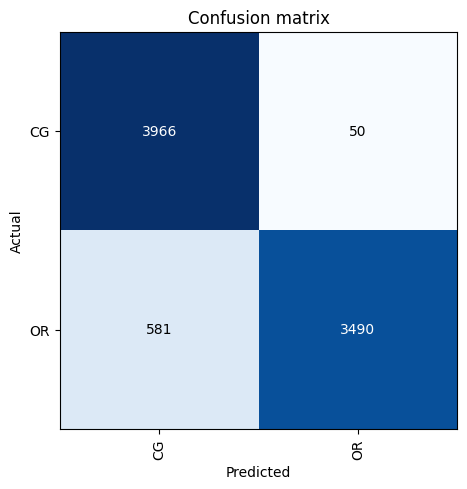

In [13]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

## Saving and loading model

At this point, if we wanted, we could save the model and it's trained weights. Later, the saved model could be loaded for making predictions.

In [14]:
learner.save('pretrained')

Path('models/pretrained.pth')

In [15]:
learner.load('pretrained')

# Language Model (ULMFiT approach)

The pretrained model in the previous section is called a language model. It was pretrained on Wikipedia on the task of guessing the next word, after reading all the words before. 

Notice, we are glossing over the details of exactly how many words are considered in making the prediction, what is the $loss function$, which $optimizer$ to use to fit the model, etc. Fastai selects intelligent defaults for all these paramaters are more.

We got great results by directly fine-tuning this language model to product review classifier, but can we do even better?

In general, with one extra step, we might do better: the Wikipedia English is slightly different from the English in our email corpus. So instead of jumping directly to the classifier, we could fine-tune our pretrained language model to the review corpus and use that as the base for our classifier.

Create the data loader for language modeling by setting $is\_lm=True$ . We set aside 10% data using **RandomSplitter** for model validation.

In [16]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df(text_cols=('text'), 
                             is_lm=True),
    get_x=ColReader('text'), 
    splitter=RandomSplitter(valid_pct=0.1, seed=12345)
    ).dataloaders(df, bs=64)

In [17]:
dls_lm.show_batch(max_n = 10)

,text,text_
0,"xxbos xxmaj great sound from this xxmaj xxunk . xxmaj the only problem is that it 's not really a stereo , but a pair of ear buds . i ca n't tell if the sound is really clear or not , but xxbos xxmaj this saw is one of the best xxmaj i 've ever owned . i have a variety of tools . xxmaj the range is amazing . i","xxmaj great sound from this xxmaj xxunk . xxmaj the only problem is that it 's not really a stereo , but a pair of ear buds . i ca n't tell if the sound is really clear or not , but xxbos xxmaj this saw is one of the best xxmaj i 've ever owned . i have a variety of tools . xxmaj the range is amazing . i have"
1,"is still working nicely . xxbos xxmaj this was a very good book ; however , it started out a little slow . i was n't really able to get into it until the middle . xxbos xxmaj so far ( had it for almost a week ) very please with this case . xxmaj it arrived in a very timely manner , and the keyboard charges and pairs with the ipad","still working nicely . xxbos xxmaj this was a very good book ; however , it started out a little slow . i was n't really able to get into it until the middle . xxbos xxmaj so far ( had it for almost a week ) very please with this case . xxmaj it arrived in a very timely manner , and the keyboard charges and pairs with the ipad xxmaj"
2,"for about a month now , and they 're still really comfortable . i do recommend getting a size up . xxmaj it 's not just that i like these shoes , i also like the color and the way they look . i will be buying more pairs of these shoes xxunk the design of this shoe . xxmaj it is pretty . i wear a 9.5 and i ordered a","about a month now , and they 're still really comfortable . i do recommend getting a size up . xxmaj it 's not just that i like these shoes , i also like the color and the way they look . i will be buying more pairs of these shoes xxunk the design of this shoe . xxmaj it is pretty . i wear a 9.5 and i ordered a 9.5"
3,"very good night vision . xxmaj the only problem you could have with these cameras is , that the night vision is so strong , that it might be too bright in close in setting .. \n xxmaj update ; xxmaj got another one of these , they shipped it really fast . xxmaj perfectly focused in the xxunk position . xxmaj mounted it adjusted a little bit . xxmaj happy camper","good night vision . xxmaj the only problem you could have with these cameras is , that the night vision is so strong , that it might be too bright in close in setting .. \n xxmaj update ; xxmaj got another one of these , they shipped it really fast . xxmaj perfectly focused in the xxunk position . xxmaj mounted it adjusted a little bit . xxmaj happy camper now"
4,1 lb sleeping bag . xxmaj the only problem is that it comes with a small mesh bag . i had to return it . xxmaj the mesh bag is the only thing i would say about this xxbos xxmaj bought this a while ago . xxmaj sorry for the late review . xxmaj this is a great flask . xxmaj keeps it ice cold all day . xxbos xxmaj my son,lb sleeping bag . xxmaj the only problem is that it comes with a small mesh bag . i had to return it . xxmaj the mesh bag is the only thing i would say about this xxbos xxmaj bought this a while ago . xxmaj sorry for the late review . xxmaj this is a great flask . xxmaj keeps it ice cold all day . xxbos xxmaj my son purchased
5,". xxup beware : it is very easy to bend the ears . so be gentle . 4 , install the rake as instructed . hope this helps . enjoy the clean rake . xxbos xxmaj all though the movie was not to great it was n't xxunk either . xxmaj the 3 stooges are not really suited for a xxunk movie , but they 3 new stooges would be good doing","xxup beware : it is very easy to bend the ears . so be gentle . 4 , install the rake as instructed . hope this helps . enjoy the clean rake . xxbos xxmaj all though the movie was not to great it was n't xxunk either . xxmaj the 3 stooges are not really suited for a xxunk movie , but they 3 new stooges would be good doing xxup"
6,"'

Next we create a language model learner.

Use Perplexity metric to track LLM performance (among how many words the model is confused at predicting next word).

In [18]:
lm_learner = language_model_learner(
            dls_lm, 
            AWD_LSTM, 
            wd=0.1,
            metrics=[Perplexity()]).to_fp16()

Once more, we find the optimal learning rate.

SuggestedLRs(valley=0.0063095735386013985)

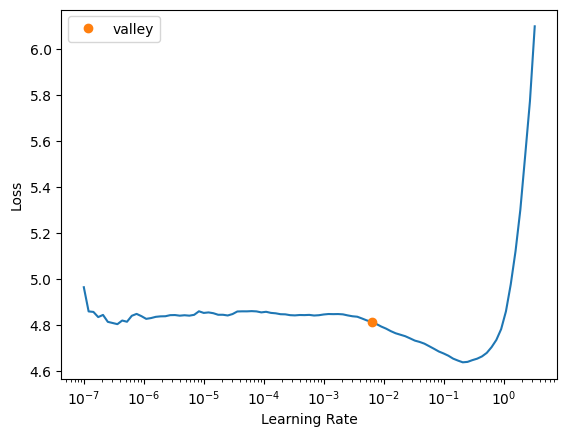

In [19]:
lr = lm_learner.lr_find()
lr

Next, we train the model for 1 epoch. By default, aside from the final
layers, other inner layers of the model are $frozen$. 

In other words, the pre-trained language model is kept intact, the essence of of **transfer learning**.

In [20]:
lm_learner.fit_one_cycle(1, lr[0])

epoch,train_loss,valid_loss,perplexity,time
0,3.681517,3.402245,30.031439,02:51


Save language model state after 1 epoch.

In [21]:
lm_learner.save('1epoch')

Path('models/1epoch.pth')

Next, we unfreeze all layers of model for futher tuning.

In [22]:
lm_learner.unfreeze()

As before, find the optimal learning rate.

SuggestedLRs(valley=3.630780702224001e-05)

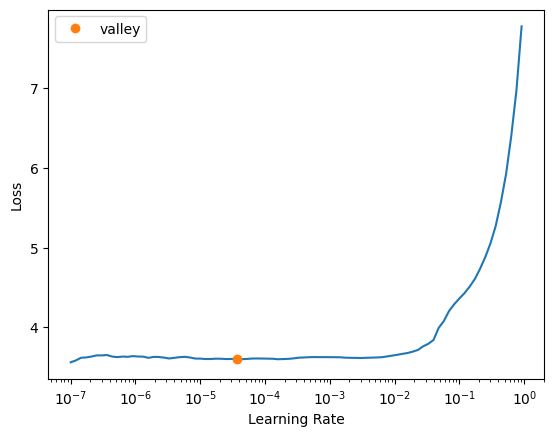

In [23]:
lr = lm_learner.lr_find()
lr

Train language model for 3 epochs.

In [24]:
lm_learner.fit_one_cycle(3, lr[0])

epoch,train_loss,valid_loss,perplexity,time
0,3.578676,3.325600,27.815674,02:57
1,3.464225,3.286367,26.745520,02:55
2,3.483678,3.281260,26.609274,02:57


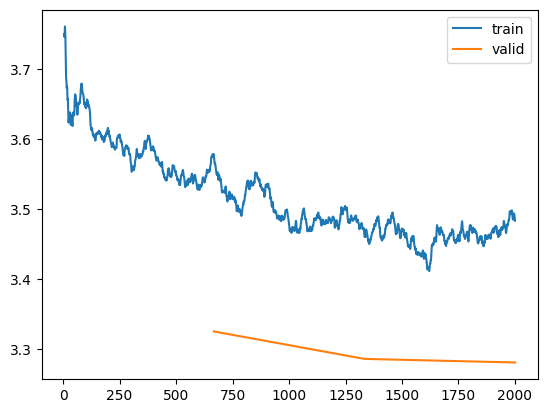

In [25]:
lm_learner.recorder.plot_loss()

Save the fully tuned model.

In [26]:
lm_learner.save_encoder('finetuned')

Recall, the original classifier we built was great. However, being motivated, we will use the new LLM to build a classifier with the hope of beating the previous model. Game on!

Create DataLoaders for classification using the domain specific language model. Notice, we set $is\_lm=False$ and use the vocabulary list from the LLM by setting $vocab=dls\_lm.vocab$.

In [27]:
dls_cls = DataBlock(
            blocks=(TextBlock.from_df(text_cols=('text'), 
                              is_lm=False, 
                              vocab=dls_lm.vocab), 
            CategoryBlock),
            get_x=ColReader('text'),
            get_y=ColReader('label'), 
            splitter=RandomSplitter(valid_pct=0.2, 
                                    seed=12345)
            ).dataloaders(df, bs=64)

In [28]:
dls_cls.show_batch(max_n=3)

,text,category
0,"xxbos i compared this rawhide to & < a data - hook=""product - link - linked "" class=""a - link - normal "" href= "" / good - buddy - usa - rawhide - braided - sticks - for - dogs-7 - to-8 - inch-2 - count - pack - of-1 / dp / xxup b005gwvwja / ref = cm_cr_arp_d_rvw_txt?ie = utf8"">good xxmaj buddy xxup usa xxmaj rawhide xxmaj braided xxmaj sticks for xxmaj dogs , 7 to 8 - inch , 2 xxmaj count ( pack of 1 ) < / a > & for my 3 year old labradoodle . \n\n xxup where xxup it xxup is xxup made : xxmaj this is made in xxup china . xxmaj the & < a data - hook=""product - link - linked "" class=""a - link - normal "" href= "" / good - buddy - usa - rawhide -",OR
1,"xxbos xxmaj this is a classy looking watch . i do n't get much opportunity to "" dress up "" these days , and its nice to have an inexpensive watch to have "" on reserve "" for those events where it does happen . xxmaj typically xxmaj i 'm wearing my casio tough solar watch with a suit , and it does n't look right ( even if it is a good representation of "" the real me "" ) . \n\n xxmaj now with the xxmaj xxunk xxmaj i 'll have an appropriate watch to wear "" occasionally "" . \n\n xxmaj you may want to pick up a watch sizing kit , i have one because xxmaj i 'm buying most of my watches online these days . xxmaj this is the one i have : & < a data - hook=""product - link - linked """,OR
2,"xxbos ( source : i xxunk a digital copy of this book for free on a read - to - review basis . xxmaj thanks to author xxmaj kris xxmaj xxunk . ) \n xxmaj erin is good at tennis , but while she likes it , it does n't mean everything to her , not the way it does to her mom . xxmaj erin 's mom is determined that xxmaj erin use her talent for tennis , and become something really good , but xxmaj erin just wants to have a normal life . \n\n xxmaj one day whilst visiting her grandmother , xxmaj erin finds herself sent back in time to 1970 , where she has the chance to play tennis against her mother . \n xxmaj who will win the match ? xxmaj is xxmaj erin better than her mother ? xxmaj and how will xxmaj",OR


Create text classification learner and use the LLM as the encoder.

In [29]:
learn = text_classifier_learner(dls_cls, 
                                AWD_LSTM, 
                                drop_mult=0.5, 
                                metrics=[accuracy, Precision(), Recall(), F1Score()])
learn = learn.load_encoder('finetuned')

Find the optimal learning rate.

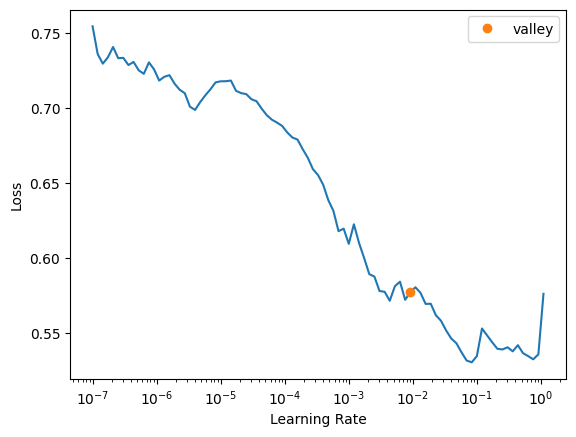

In [30]:
lr = learn.lr_find()

And tune the model for 3 epochs.

In [31]:
learn.fine_tune(3, lr[0])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.323608,0.242557,0.898095,0.934955,0.853756,0.892512,01:09


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.195852,0.141835,0.938412,0.981609,0.892438,0.934902,02:19
1,0.174162,0.210898,0.922953,0.994448,0.849264,0.916139,02:19
2,0.082811,0.225423,0.929879,0.997110,0.860993,0.924066,02:19


 ## New model performance

 The new model has marginally better *precision* ($99\%$ versus $98\%$) and *recall* ($86\%$ versus $85\%$).
 
 The confusion matrix shows the new model has performed better overall (567 total missclassifications, previously 631).

 So, is the new model truly better? The answer is *yes*. Since the key objective was to identify fake (computer generated) reviews, the new model has performed better by misclassifying fewer CGs (10 versus 50).

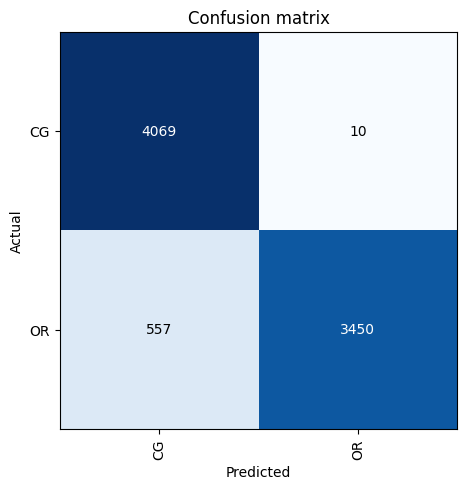

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Finally, let's use the LLM for text generation (NLG). Text generation involves prompting with some text and asking the model to generate additional text.

The generated text is not very sophisticated but kind of makes sense. One could experiment with various settings, e.g. *temperature*, to get different results.

In [41]:
N_WORDS = 40
temperature = 0.75
PROMPTS = ["My husband is hard of hearing and would have difficult time", 
           "I have never encountered such an easy method", 
           "The quality is unquestionable"]

preds = [lm_learner.predict(p, N_WORDS, temperature=temperature) for p in PROMPTS]

for idx in range(len(PROMPTS)):
  print(f'{idx}: {preds[idx]}')

0: My husband is hard of hearing and would have difficult time getting through the house . This is a good product for this price . It 's very easy to use and the fit is good ! Great product . Works great . My
1: i have never encountered such an easy method to make a lens , and i am very pleased with the purchase . i am very pleased with the quality of this product . It is a great buy for my son , and once he is able
2: The quality is xxunk and the picture is pretty . The only downside is that the plastic parts are not very sturdy . The plastic part is very hard to clean and it is not the only one that holds a lot


## Conclusion

Through the implementation of this project we have explored NLP, NLU, and NLG concepts using Fastai.

We have trained a LLM model that that has better classification performance and is also capable of text generation. The ability to build domain specific LLMs on readily available Google Colab infrastructutre is a game changer and make NLP/ML innovation available to citizen developers.